In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})
from matplotlib.ticker import FuncFormatter
import numpy as np
import darksector as ds
import standardmodel as sm
import constants as c
import pickle
from scipy import special, interpolate

# Load the data

In [2]:
# Load the pickle file with the data
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)

T_SM_final = data_dict['T_SM_domain'][-1]
T_DS_interp = interpolate.RegularGridInterpolator((data_dict['sinsq2theta_values'], data_dict['ms1_values']), 
                                                  data_dict['T_DS_domain'][:,:,0,-1], method='linear')
# Create a dense 2D grid of T_DS values, with dimensions (sinsq2theta, ms1)
num = 100
ms1_dense = np.logspace(np.log10(np.min(data_dict['ms1_values'])), np.log10(np.max(data_dict['ms1_values'])), num)
sinsq2theta_dense = np.logspace(np.log10(np.min(data_dict['sinsq2theta_values'])), np.log10(np.max(data_dict['sinsq2theta_values'])), num)

T_DS_dense = []
for ms1 in ms1_dense:
    for sinsq2theta in sinsq2theta_dense:
        T_DS_dense.append(T_DS_interp((sinsq2theta, ms1)))
T_DS_dense = np.array(T_DS_dense).reshape((len(ms1_dense), len(sinsq2theta_dense)))

# Convert to the temperature today, given the dilution from the decrease in relativistic degrees of freedom
scale_factor_ratio = (c.Tcmb/T_SM_final)*(sm.compute_SM_relativistic_dof_approx(c.Tcmb)/sm.compute_SM_relativistic_dof_approx(T_SM_final))**(1/3.0)
T_DS_dense_today = T_DS_dense*scale_factor_ratio


# Approximate Analytic Results

## $T_{DS}$

In [3]:
# The actual data
temp_ratio = T_DS_dense_today/c.Tcmb

# Define the approximate function
def T_DS_approximate(sinsq2theta, ms):
    """Gives the tempreature in MeV"""
    n_dens_conversion = 2*np.pi**2/(3*special.zeta(3)) #divided by m4
    omega_m_hsq = 0.3*(sinsq2theta/10**-10)*(ms/0.1)**2/ms #times m4
    return (c.rho_crit_over_hsq*omega_m_hsq*n_dens_conversion)**(1./3)

# Create an array for the approximate T_DS values
T_DS_approx = []
for ms1 in ms1_dense:
    for sinsq2theta in sinsq2theta_dense:
        T_DS_approx.append(T_DS_approximate(sinsq2theta, ms1))
T_DS_approx = np.array(T_DS_approx).reshape((len(ms1_dense), len(sinsq2theta_dense)))

temp_ratio_approx = T_DS_approx/c.Tcmb

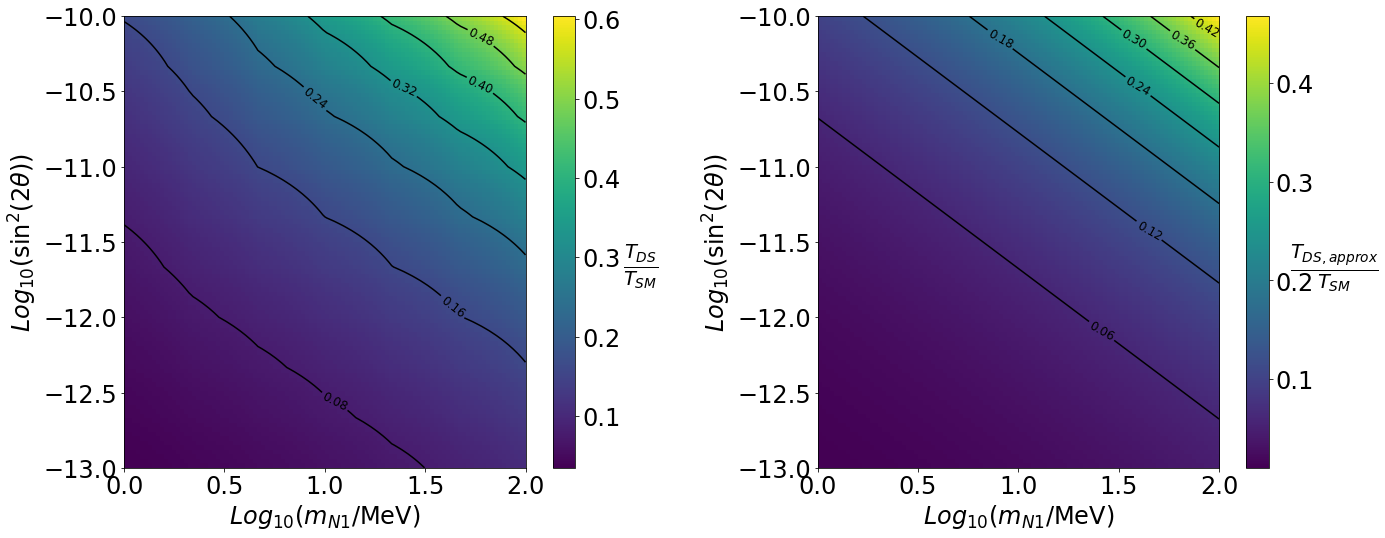

In [4]:
# Set up the figure and the two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot with real data
im = axs[0].imshow(temp_ratio.T, origin='lower',
                  extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
contours = axs[0].contour(X, Y, temp_ratio.T, colors='k')  # 'k' means black
axs[0].clabel(contours, inline=True, fontsize=12)

axs[0].set_xlabel(r'$Log_{10}(m_{N1}$/MeV)')
axs[0].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')

cb = fig.colorbar(im, ax=axs[0])
cb.set_label(r'$\frac{T_{DS}}{T_{SM}}$', rotation=0, labelpad=20, fontsize=28)
axs[0].set_aspect(0.75)

# Plot with approximate data
im_approx = axs[1].imshow(temp_ratio_approx.T, origin='lower',
                          extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                  np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

contours_approx = axs[1].contour(X, Y, temp_ratio_approx.T, colors='k')  # 'k' means black
axs[1].clabel(contours_approx, inline=True, fontsize=12)

axs[1].set_xlabel(r'$Log_{10}(m_{N1}$/MeV)')
axs[1].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')

cb_approx = fig.colorbar(im_approx, ax=axs[1])
cb_approx.set_label(r'$\frac{T_{DS,approx}}{T_{SM}}$', rotation=0, labelpad=20, fontsize=28)
axs[1].set_aspect(0.75)

# Ensure the layout is tight
plt.tight_layout()
plt.show()


## $m_{s2}$ needed to make all of the dark matter

In [5]:
# The actual data
ms2_required = [10**3*c.rho_crit_over_hsq*0.12/ds.compute_current_DM_ndens(T_SM_final, T_DS) for T_DS in T_DS_dense.flatten()]
ms2_required = np.array(ms2_required).reshape((len(ms1_dense), len(sinsq2theta_dense)))

# The approximate result
def approx_ms2_required(sinsq2theta, ms1):
    return (0.12/0.3)*(10**-10/sinsq2theta)*(0.1/ms1)**2*ms1

# Define the approximate function
def approx_ms2_required(sinsq2theta, ms1):
    return (0.12/0.3)*(10**-10/sinsq2theta)*(0.1/ms1)**2*ms1

ms2_approx_required = [approx_ms2_required(sinsq2theta, ms1) for ms1 in ms1_dense for sinsq2theta in sinsq2theta_dense]
ms2_approx_required = np.array(ms2_approx_required).reshape((len(ms1_dense), len(sinsq2theta_dense)))


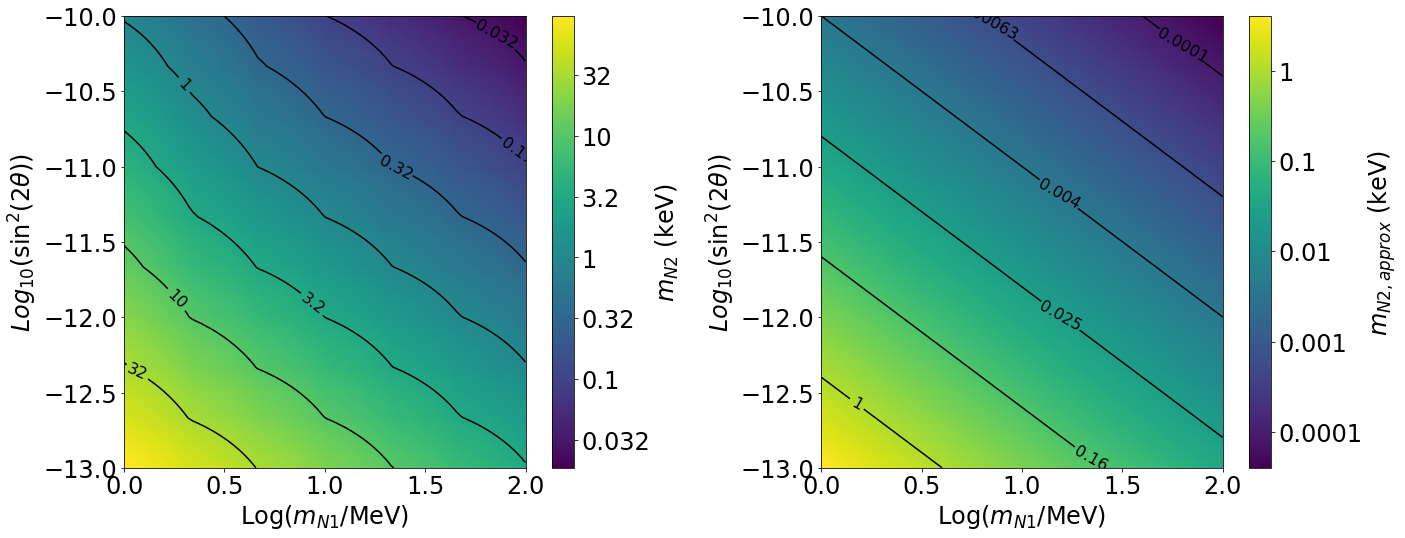

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = axs[0].contour(X, Y, np.log10(ms2_required.T), colors='k', linestyles='solid')
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
axs[0].clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

im = axs[0].imshow(np.log10(ms2_required.T), origin='lower',
                    extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])
cb = fig.colorbar(im, ax=axs[0])
cb.set_label(r'$m_{N2}$ (keV)')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

axs[0].set_xlabel(r'Log($m_{N1}$/MeV)')
axs[0].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
axs[0].set_aspect(0.75)

contours_approx = axs[1].contour(X, Y, np.log10(ms2_approx_required.T), colors='k', linestyles='solid')
axs[1].clabel(contours_approx, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

im_approx = axs[1].imshow(np.log10(ms2_approx_required.T), origin='lower',
                          extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                  np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

cb_approx = fig.colorbar(im_approx, ax=axs[1])
cb_approx.set_label(r'$m_{N2, approx}$ (keV)')
cb_approx.formatter = FuncFormatter(format_func)
cb_approx.update_ticks()

axs[1].set_xlabel(r'Log($m_{N1}$/MeV)')
axs[1].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
axs[1].set_aspect(0.75)

plt.tight_layout()
plt.show()


# Effective Free streaming mass

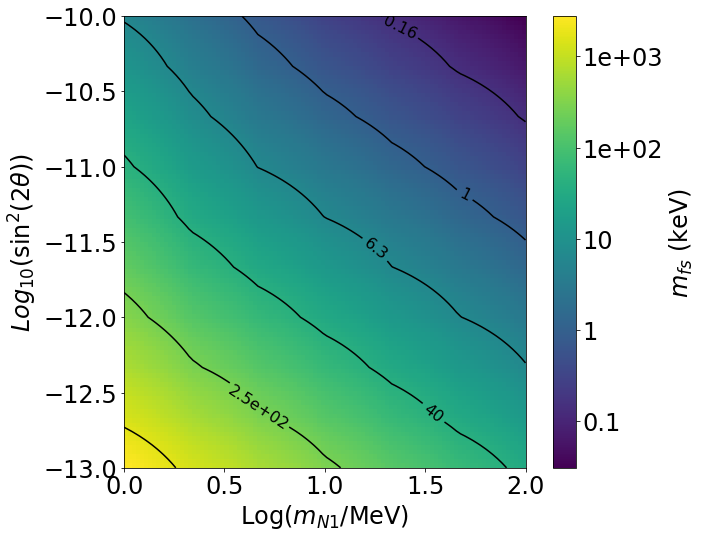

In [10]:
fs_mass = ms2_required/temp_ratio

plt.figure(figsize=(8,8))
im = plt.imshow(np.log10(fs_mass.T), origin='lower',
                    extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = plt.contour(X, Y, np.log10(fs_mass.T), colors='k', linestyles='solid')
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
plt.clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

cb = plt.colorbar(im)
cb.set_label(r'$m_{fs}$ (keV)')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

plt.xlabel(r'Log($m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
plt.gca().set_aspect(0.75)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# Check a single run

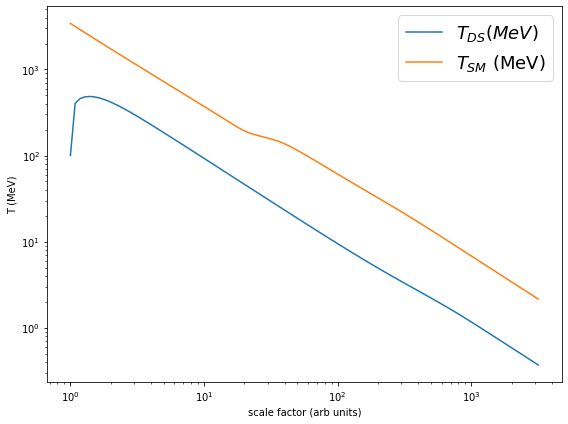

In [7]:
#import the results from results/test.npy
results = np.load('results/test.npy')
T_DS = results[0, 0, 0, :]
a_domain = np.logspace(2.5, 6., 100)
T_SM = ds.T_SM_func(a_domain)

fig, ax = plt.subplots(figsize=(8,6))
a_domain = a_domain/a_domain[0]


plt.loglog(a_domain, T_DS, label=r"$T_{DS} (MeV)$")
plt.loglog(a_domain, T_SM, label=r"$T_{SM}$ (MeV)")

plt.xlabel(r"scale factor (arb units)")
plt.ylabel(r"T (MeV)")
plt.tight_layout()
#plt.title(r'$m_{s1}$'+'={} MeV'.format(ms1) +', $m_{s2}$'+'={} MeV'.format(ms2) +r'$, sin^2(2\theta)$={}'.format(sinsq2theta))
plt.legend(fontsize=18)
plt.show()

ms1 = 100 MeV, ms2 = 0.01 MeV, sin^2(2theta) = 1e-13


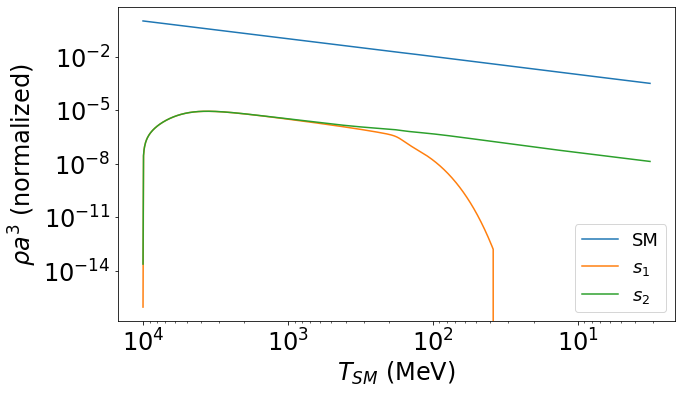

In [11]:
# import the data
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)

# Get the single model parameters
ms1_idx, sinsq2theta_idx, ms2_idx = 6, 0, 0
ms1 = data_dict['ms1_values'][ms1_idx]
ms2 = data_dict['ms2_values'][ms2_idx]
sinsq2theta = data_dict['sinsq2theta_values'][sinsq2theta_idx]
print("ms1 = {} MeV, ms2 = {} MeV, sin^2(2theta) = {}".format(
    '{:.3g}'.format(ms1), '{:.3g}'.format(ms2), '{:.3g}'.format(sinsq2theta)))

# Get the dark sector energy density
T_DS = data_dict['T_DS_domain'][sinsq2theta_idx, ms1_idx, ms2_idx, :]
a_domain = data_dict['a_domain']
rho_s1 = 2*sm.compute_energy_density(T_DS, ms1, -1)*a_domain**3
rho_s2 = 2*sm.compute_energy_density(T_DS, ms2, -1)*a_domain**3

# get the SM energy density
T_SM = data_dict['T_SM_domain']
rho_sm = ds.energy_density_func(T_SM)*a_domain**3

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(T_SM, rho_sm/rho_sm[0], label=r"SM")
plt.loglog(T_SM, rho_s1/rho_sm[0], label=r"$s_1$")
plt.loglog(T_SM, rho_s2/rho_sm[0], label=r"$s_2$")

plt.xlabel(r"$T_{SM}$ (MeV)")
plt.ylabel(r"$\rho a^3$ (normalized)")
plt.tight_layout()
plt.gca().invert_xaxis()
#plt.ylim(10**-7, 3)
plt.legend(fontsize=18)
plt.show()

# Check a grid of the final temperatures

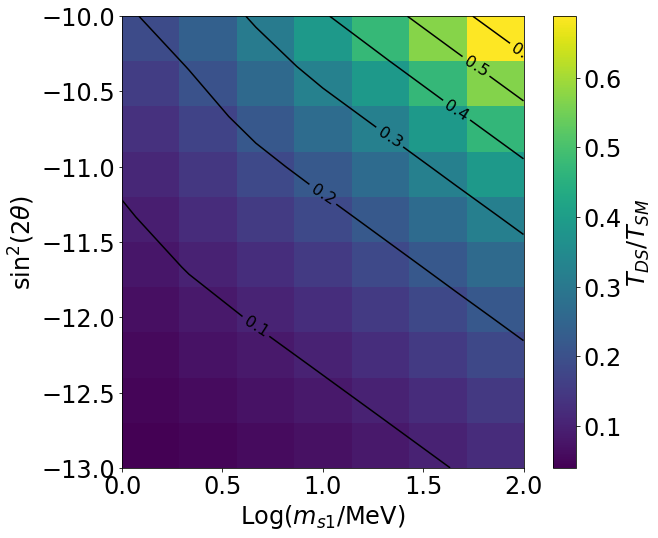

In [8]:
# Load a pickle file with the data
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)

T_SM_final = data_dict['T_SM_domain'][-1]
temp_ratio = data_dict['T_DS_domain'][:,:,0,-1]/T_SM_final

plt.figure(figsize=(8,8))
im = plt.imshow(temp_ratio, origin='lower',
                  extent=[np.log10(data_dict['ms1_values'][0]), np.log10(data_dict['ms1_values'][-1]),
                                np.log10(data_dict['sinsq2theta_values'][0]), np.log10(data_dict['sinsq2theta_values'][-1])])

X, Y = np.meshgrid(np.log10(data_dict['ms1_values']), np.log10(data_dict['sinsq2theta_values']))
contours = plt.contour(X, Y, temp_ratio, colors='k')  # 'k' means black
plt.clabel(contours, inline=True, fontsize=16)

plt.xlabel(r'Log($m_{s1}$/MeV)')
plt.ylabel(r'$\sin^2(2 \theta)$')

cb = plt.colorbar(im)
cb.set_label(r'$T_{DS}/T_{SM}$')
plt.gca().set_aspect(0.75)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

